# About this notebook  

TBD...

# Data Loading

In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
os.listdir("../input/cassava-leaf-disease-classification")

['train_tfrecords',
 'train_images',
 'test_images',
 'label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'test_tfrecords']

In [3]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3
test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")
display(train.head())
display(test.head())
display(label_map)

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

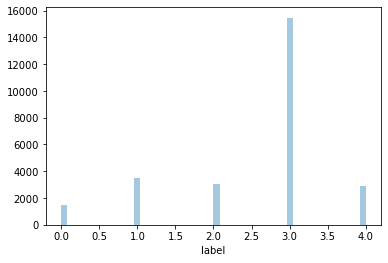

In [4]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = True
    print_freq = 100
    num_workers = 4
    model_name = "seresnext50_32x4d"  # resnext50_32x4d, seresnext50_32x4d, tf_efficientnet_b3_ns, tf_efficientnet_b4_ns, vit_base_patch16_384, deit_base_patch16_384
    batch_size = 24
    gradient_accumulation_steps = 1
    size = 384 if "it_base_" in model_name else 512
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.2
    scheduler = "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = True
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    )  # CosineAnnealingWarmRestarts
    # first_cycle_steps = (
    #     len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    # )  # CosineAnnealingWarmupRestarts for batch update
    # warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    # gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 1e-4
    min_lr = 2e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 3456
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CenterCrop,
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         299
      1         695
      2         604
      3        3092
      4         578
1     0         299
      1         695
      2         604
      3        3092
      4         578
2     0         298
      1         695
      2         603
      3        3093
      4         578
3     0         298
      1         695
      2         603
      3        3093
      4         578
4     0         298
      1         696
      2         603
      3        3092
      4         578
dtype: int64


# Dataset

In [10]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).long()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

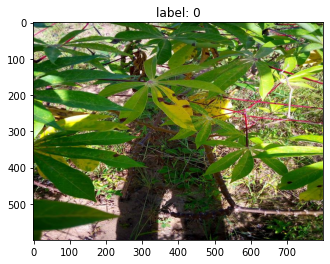

In [11]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transforms

In [12]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                CenterCrop(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

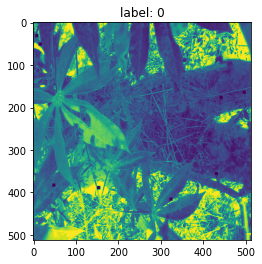

In [13]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# CutMix / FMix


In [14]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets


def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    if CFG.apex:
        # mask = torch.tensor(mask, device=device).float()
        mask = mask.astype(np.float32)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, shuffled_targets, lam)

    return (x1 + x2), targets

# MixUp

In [15]:
# https://github.com/yuhao318/mwh/blob/e9e2da8fc6/utils.py
def mixup(x, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## SYM
    # mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = (1 - lam) * x + lam * x[index,:]
    # mixed_image  = torch.cat([mixed_x,mixed_y], 0)
    # y_a, y_b = y, y[index]
    # mixed_label  = torch.cat([y_a,y_b], 0)

    ## Reduce batch size
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    ## Only Alpha
    # mixed_x = 0.5 * x + (1 - 0.5) * x[index,:]
    # mixed_image  = mixed_x
    # y_a, y_b = y, y[index]
    # ind_label = torch.randint_like(y, 0,2)
    # mixed_label  = ind_label * y_a + (1-ind_label) * y_b

    ## Reduce batch size and SYM
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j
    # mixed_y = (1 - lam) * x_i + lam * x_j
    # mixed_x  = torch.cat([mixed_x,mixed_y], 0)
    # y_b = torch.cat([y_b,y_a], 0)
    # y_a = y

    # return mixed_image, mixed_label, lam
    return mixed_x, (y_a, y_b, lam)

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name

        if model_name.startswith("deit_"):
            self.model = torch.hub.load("facebookresearch/deit:main", model_name, pretrained=True)

            if model_name == "deit_base_patch16_384":
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)

            if "resnext50_32x4d" in model_name:
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("tf_efficientnet"):
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("vit_"):
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

    if CFG.model_name.startswith("vit_"):
        try:
            for m in model.modules():
                if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                    m.eval()
        except ValuError:
            print("error with batchnorm2d or layernorm")
            return

In [18]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)
# print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.0300,  0.6243,  0.1679, -0.1099, -0.4241],
        [-0.0866,  0.6408,  0.2015, -0.1033, -0.3610],
        [-0.1117,  0.5691,  0.2299, -0.0624, -0.3747],
        [-0.2299,  0.6055,  0.2559,  0.0412, -0.4098]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [19]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

# Helper functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # CutMix, FMix
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            mix_decision = 0.75  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if epoch >= CFG.epochs - 4:
            mix_decision *= 2  # Reduce probability

        if mix_decision < 0.25:
            images, labels = cutmix(images, labels, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(images, labels, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size))
        elif mix_decision >= 0.5 and mix_decision < 0.75:
            images, labels = mixup(images, labels, alpha=0.5)

        y_preds = model(images.float())

        if mix_decision < 0.75:
            loss = criterion(y_preds, labels[0]) * labels[2] + criterion(y_preds, labels[1]) * (1.0 - labels[2])
        else:
            loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not CFG.apex:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [23]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext50_32x4d_racm-a304a460.pth" to /root/.cache/torch/hub/checkpoints/seresnext50_32x4d_racm-a304a460.pth


Epoch: [1][0/877] Elapsed 0m 7s (remain 110m 4s) Loss: 0.3193(0.3193) Grad: 0.5409 LR: 0.000100  
Epoch: [1][100/877] Elapsed 1m 24s (remain 10m 50s) Loss: 0.1191(0.1704) Grad: 0.4317 LR: 0.000100  
Epoch: [1][200/877] Elapsed 2m 41s (remain 9m 2s) Loss: 0.0721(0.1387) Grad: 0.4600 LR: 0.000100  
Epoch: [1][300/877] Elapsed 3m 58s (remain 7m 36s) Loss: 0.1291(0.1240) Grad: 0.4978 LR: 0.000100  
Epoch: [1][400/877] Elapsed 5m 15s (remain 6m 14s) Loss: 0.0910(0.1150) Grad: 0.5555 LR: 0.000099  
Epoch: [1][500/877] Elapsed 6m 32s (remain 4m 54s) Loss: 0.0861(0.1094) Grad: 0.6351 LR: 0.000099  
Epoch: [1][600/877] Elapsed 7m 48s (remain 3m 35s) Loss: 0.0751(0.1057) Grad: 0.6176 LR: 0.000099  
Epoch: [1][700/877] Elapsed 9m 5s (remain 2m 17s) Loss: 0.0608(0.1015) Grad: 0.3764 LR: 0.000098  
Epoch: [1][800/877] Elapsed 10m 22s (remain 0m 59s) Loss: 0.1400(0.0983) Grad: 0.6448 LR: 0.000098  
Epoch: [1][876/877] Elapsed 11m 21s (remain 0m 0s) Loss: 0.0339(0.0961) Grad: 0.4891 LR: 0.000098  
EV

Epoch 1 - avg_train_loss: 0.0961  avg_val_loss: 0.0663  time: 746s
Epoch 1 - Accuracy: 0.8851556567957479
Epoch 1 - Save Best Score: 0.8852 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1302(0.0663) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 21m 44s) Loss: 0.0472(0.0472) Grad: 0.5425 LR: 0.000098  
Epoch: [2][100/877] Elapsed 1m 18s (remain 9m 59s) Loss: 0.0659(0.0529) Grad: 0.5953 LR: 0.000097  
Epoch: [2][200/877] Elapsed 2m 34s (remain 8m 40s) Loss: 0.0640(0.0519) Grad: 0.6241 LR: 0.000096  
Epoch: [2][300/877] Elapsed 3m 51s (remain 7m 22s) Loss: 0.0583(0.0551) Grad: 0.3176 LR: 0.000096  
Epoch: [2][400/877] Elapsed 5m 7s (remain 6m 5s) Loss: 0.0285(0.0551) Grad: 0.3462 LR: 0.000095  
Epoch: [2][500/877] Elapsed 6m 24s (remain 4m 48s) Loss: 0.0336(0.0558) Grad: 0.4829 LR: 0.000094  
Epoch: [2][600/877] Elapsed 7m 40s (remain 3m 31s) Loss: 0.0621(0.0559) Grad: 0.4127 LR: 0.000093  
Epoch: [2][700/877] Elapsed 8m 57s (remain 2m 14s) Loss: 0.0923(0.0559) Grad: 0.6041 LR: 0.000092  
Epoch: [2][800/877] Elapsed 10m 13s (remain 0m 58s) Loss: 0.0718(0.0563) Grad: 0.3360 LR: 0.000091  
Epoch: [2][876/877] Elapsed 11m 12s 

Epoch 2 - avg_train_loss: 0.0562  avg_val_loss: 0.0670  time: 737s
Epoch 2 - Accuracy: 0.8899012908124525
Epoch 2 - Save Best Score: 0.8899 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1262(0.0670) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 26m 29s) Loss: 0.1104(0.1104) Grad: 0.7045 LR: 0.000091  
Epoch: [3][100/877] Elapsed 1m 19s (remain 10m 11s) Loss: 0.0885(0.1425) Grad: 0.4901 LR: 0.000090  
Epoch: [3][200/877] Elapsed 2m 37s (remain 8m 50s) Loss: 0.1235(0.1377) Grad: 0.4457 LR: 0.000088  
Epoch: [3][300/877] Elapsed 3m 55s (remain 7m 30s) Loss: 0.1784(0.1382) Grad: 0.4098 LR: 0.000087  
Epoch: [3][400/877] Elapsed 5m 13s (remain 6m 12s) Loss: 0.1275(0.1377) Grad: 0.2401 LR: 0.000086  
Epoch: [3][500/877] Elapsed 6m 31s (remain 4m 53s) Loss: 0.0629(0.1364) Grad: 0.3752 LR: 0.000085  
Epoch: [3][600/877] Elapsed 7m 49s (remain 3m 35s) Loss: 0.1469(0.1336) Grad: 0.3496 LR: 0.000084  
Epoch: [3][700/877] Elapsed 9m 7s (remain 2m 17s) Loss: 0.1214(0.1340) Grad: 0.3527 LR: 0.000082  
Epoch: [3][800/877] Elapsed 10m 25s (remain 0m 59s) Loss: 0.1537(0.1345) Grad: 0.3055 LR: 0.000081  
Epoch: [3][876/877] Elapsed 11m 24

Epoch 3 - avg_train_loss: 0.1345  avg_val_loss: 0.0745  time: 749s
Epoch 3 - Accuracy: 0.8809794988610479


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1328(0.0745) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 27m 42s) Loss: 0.1477(0.1477) Grad: 0.3030 LR: 0.000080  
Epoch: [4][100/877] Elapsed 1m 19s (remain 10m 12s) Loss: 0.0815(0.1253) Grad: 0.3987 LR: 0.000078  
Epoch: [4][200/877] Elapsed 2m 37s (remain 8m 49s) Loss: 0.1756(0.1282) Grad: 0.3500 LR: 0.000077  
Epoch: [4][300/877] Elapsed 3m 55s (remain 7m 30s) Loss: 0.0464(0.1296) Grad: 0.3142 LR: 0.000075  
Epoch: [4][400/877] Elapsed 5m 13s (remain 6m 11s) Loss: 0.1838(0.1297) Grad: 0.3548 LR: 0.000074  
Epoch: [4][500/877] Elapsed 6m 30s (remain 4m 53s) Loss: 0.1541(0.1295) Grad: 0.6210 LR: 0.000072  
Epoch: [4][600/877] Elapsed 7m 48s (remain 3m 35s) Loss: 0.2171(0.1281) Grad: 0.5267 LR: 0.000071  
Epoch: [4][700/877] Elapsed 9m 6s (remain 2m 17s) Loss: 0.1037(0.1280) Grad: 0.3833 LR: 0.000069  
Epoch: [4][800/877] Elapsed 10m 24s (remain 0m 59s) Loss: 0.0562(0.1276) Grad: 0.4020 LR: 0.000067  
Epoch: [4][876/877] Elapsed 11m 23

Epoch 4 - avg_train_loss: 0.1276  avg_val_loss: 0.0668  time: 748s
Epoch 4 - Accuracy: 0.8912300683371298
Epoch 4 - Save Best Score: 0.8912 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1319(0.0668) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 26m 25s) Loss: 0.0829(0.0829) Grad: 0.4885 LR: 0.000066  
Epoch: [5][100/877] Elapsed 1m 19s (remain 10m 9s) Loss: 0.1290(0.1227) Grad: 0.2187 LR: 0.000064  
Epoch: [5][200/877] Elapsed 2m 37s (remain 8m 48s) Loss: 0.1062(0.1240) Grad: 0.3871 LR: 0.000063  
Epoch: [5][300/877] Elapsed 3m 54s (remain 7m 29s) Loss: 0.1460(0.1242) Grad: 0.3250 LR: 0.000061  
Epoch: [5][400/877] Elapsed 5m 12s (remain 6m 11s) Loss: 0.1874(0.1244) Grad: 0.3664 LR: 0.000059  
Epoch: [5][500/877] Elapsed 6m 30s (remain 4m 53s) Loss: 0.2366(0.1239) Grad: 0.5720 LR: 0.000058  
Epoch: [5][600/877] Elapsed 7m 48s (remain 3m 34s) Loss: 0.1472(0.1243) Grad: 0.3247 LR: 0.000056  
Epoch: [5][700/877] Elapsed 9m 5s (remain 2m 16s) Loss: 0.2184(0.1243) Grad: 0.3646 LR: 0.000054  
Epoch: [5][800/877] Elapsed 10m 23s (remain 0m 59s) Loss: 0.0614(0.1246) Grad: 0.5909 LR: 0.000052  
Epoch: [5][876/877] Elapsed 11m 22s

Epoch 5 - avg_train_loss: 0.1237  avg_val_loss: 0.0651  time: 747s
Epoch 5 - Accuracy: 0.8925588458618071
Epoch 5 - Save Best Score: 0.8926 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1243(0.0651) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 27m 36s) Loss: 0.0772(0.0772) Grad: 0.2016 LR: 0.000051  
Epoch: [6][100/877] Elapsed 1m 19s (remain 10m 12s) Loss: 0.0742(0.1238) Grad: 0.3340 LR: 0.000049  
Epoch: [6][200/877] Elapsed 2m 37s (remain 8m 49s) Loss: 0.1895(0.1229) Grad: 0.3104 LR: 0.000048  
Epoch: [6][300/877] Elapsed 3m 55s (remain 7m 30s) Loss: 0.1101(0.1233) Grad: 0.4927 LR: 0.000046  
Epoch: [6][400/877] Elapsed 5m 13s (remain 6m 11s) Loss: 0.1039(0.1234) Grad: 0.4529 LR: 0.000044  
Epoch: [6][500/877] Elapsed 6m 30s (remain 4m 53s) Loss: 0.1069(0.1240) Grad: 0.4453 LR: 0.000042  
Epoch: [6][600/877] Elapsed 7m 48s (remain 3m 35s) Loss: 0.1258(0.1231) Grad: 0.4466 LR: 0.000041  
Epoch: [6][700/877] Elapsed 9m 6s (remain 2m 17s) Loss: 0.1180(0.1224) Grad: 0.2645 LR: 0.000039  
Epoch: [6][800/877] Elapsed 10m 24s (remain 0m 59s) Loss: 0.0466(0.1229) Grad: 0.3664 LR: 0.000037  
Epoch: [6][876/877] Elapsed 11m 23

Epoch 6 - avg_train_loss: 0.1227  avg_val_loss: 0.0652  time: 748s
Epoch 6 - Accuracy: 0.8925588458618071


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1174(0.0652) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 26m 12s) Loss: 0.1198(0.1198) Grad: 0.4243 LR: 0.000036  
Epoch: [7][100/877] Elapsed 1m 18s (remain 10m 6s) Loss: 0.0551(0.0911) Grad: 0.4795 LR: 0.000034  
Epoch: [7][200/877] Elapsed 2m 35s (remain 8m 44s) Loss: 0.0951(0.0886) Grad: 0.5180 LR: 0.000033  
Epoch: [7][300/877] Elapsed 3m 52s (remain 7m 25s) Loss: 0.0527(0.0891) Grad: 0.3995 LR: 0.000031  
Epoch: [7][400/877] Elapsed 5m 10s (remain 6m 8s) Loss: 0.1392(0.0930) Grad: 0.2340 LR: 0.000029  
Epoch: [7][500/877] Elapsed 6m 27s (remain 4m 50s) Loss: 0.0879(0.0944) Grad: 0.7394 LR: 0.000028  
Epoch: [7][600/877] Elapsed 7m 44s (remain 3m 33s) Loss: 0.0992(0.0943) Grad: 0.3722 LR: 0.000026  
Epoch: [7][700/877] Elapsed 9m 1s (remain 2m 16s) Loss: 0.1326(0.0944) Grad: 0.4415 LR: 0.000025  
Epoch: [7][800/877] Elapsed 10m 18s (remain 0m 58s) Loss: 0.0912(0.0946) Grad: 0.5267 LR: 0.000023  
Epoch: [7][876/877] Elapsed 11m 17s 

Epoch 7 - avg_train_loss: 0.0941  avg_val_loss: 0.0632  time: 742s
Epoch 7 - Accuracy: 0.8938876233864844
Epoch 7 - Save Best Score: 0.8939 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1112(0.0632) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 26m 48s) Loss: 0.0254(0.0254) Grad: 0.3962 LR: 0.000022  
Epoch: [8][100/877] Elapsed 1m 18s (remain 10m 6s) Loss: 0.1488(0.0951) Grad: 0.2808 LR: 0.000021  
Epoch: [8][200/877] Elapsed 2m 36s (remain 8m 45s) Loss: 0.0563(0.0923) Grad: 0.3246 LR: 0.000019  
Epoch: [8][300/877] Elapsed 3m 53s (remain 7m 27s) Loss: 0.1299(0.0926) Grad: 0.5760 LR: 0.000018  
Epoch: [8][400/877] Elapsed 5m 11s (remain 6m 9s) Loss: 0.0570(0.0923) Grad: 0.5024 LR: 0.000017  
Epoch: [8][500/877] Elapsed 6m 28s (remain 4m 51s) Loss: 0.1711(0.0927) Grad: 0.3638 LR: 0.000016  
Epoch: [8][600/877] Elapsed 7m 45s (remain 3m 33s) Loss: 0.0404(0.0924) Grad: 0.4117 LR: 0.000014  
Epoch: [8][700/877] Elapsed 9m 3s (remain 2m 16s) Loss: 0.1996(0.0925) Grad: 0.4714 LR: 0.000013  
Epoch: [8][800/877] Elapsed 10m 20s (remain 0m 58s) Loss: 0.1814(0.0921) Grad: 0.2951 LR: 0.000012  
Epoch: [8][876/877] Elapsed 11m 19s 

Epoch 8 - avg_train_loss: 0.0928  avg_val_loss: 0.0618  time: 744s
Epoch 8 - Accuracy: 0.8954062262718299
Epoch 8 - Save Best Score: 0.8954 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1139(0.0618) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 26m 31s) Loss: 0.1096(0.1096) Grad: 0.3945 LR: 0.000011  
Epoch: [9][100/877] Elapsed 1m 18s (remain 10m 5s) Loss: 0.0925(0.0843) Grad: 0.3884 LR: 0.000010  
Epoch: [9][200/877] Elapsed 2m 36s (remain 8m 45s) Loss: 0.1772(0.0931) Grad: 0.2608 LR: 0.000009  
Epoch: [9][300/877] Elapsed 3m 53s (remain 7m 26s) Loss: 0.1542(0.0921) Grad: 0.3396 LR: 0.000009  
Epoch: [9][400/877] Elapsed 5m 10s (remain 6m 8s) Loss: 0.1812(0.0910) Grad: 0.4328 LR: 0.000008  
Epoch: [9][500/877] Elapsed 6m 27s (remain 4m 50s) Loss: 0.1286(0.0894) Grad: 0.4530 LR: 0.000007  
Epoch: [9][600/877] Elapsed 7m 44s (remain 3m 33s) Loss: 0.0333(0.0883) Grad: 0.2837 LR: 0.000006  
Epoch: [9][700/877] Elapsed 9m 1s (remain 2m 16s) Loss: 0.2047(0.0881) Grad: 0.5192 LR: 0.000005  
Epoch: [9][800/877] Elapsed 10m 18s (remain 0m 58s) Loss: 0.1226(0.0877) Grad: 0.2738 LR: 0.000005  
Epoch: [9][876/877] Elapsed 11m 17s 

Epoch 9 - avg_train_loss: 0.0886  avg_val_loss: 0.0616  time: 742s
Epoch 9 - Accuracy: 0.8973044798785118
Epoch 9 - Save Best Score: 0.8973 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1228(0.0616) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 23m 48s) Loss: 0.0320(0.0320) Grad: 0.3058 LR: 0.000004  
Epoch: [10][100/877] Elapsed 1m 18s (remain 10m 1s) Loss: 0.0699(0.0406) Grad: 0.4270 LR: 0.000004  
Epoch: [10][200/877] Elapsed 2m 34s (remain 8m 40s) Loss: 0.0662(0.0401) Grad: 0.5021 LR: 0.000003  
Epoch: [10][300/877] Elapsed 3m 51s (remain 7m 22s) Loss: 0.0768(0.0395) Grad: 0.4155 LR: 0.000003  
Epoch: [10][400/877] Elapsed 5m 7s (remain 6m 5s) Loss: 0.0307(0.0388) Grad: 0.4145 LR: 0.000003  
Epoch: [10][500/877] Elapsed 6m 24s (remain 4m 48s) Loss: 0.0248(0.0383) Grad: 0.3382 LR: 0.000002  
Epoch: [10][600/877] Elapsed 7m 40s (remain 3m 31s) Loss: 0.0132(0.0373) Grad: 0.2661 LR: 0.000002  
Epoch: [10][700/877] Elapsed 8m 57s (remain 2m 14s) Loss: 0.0080(0.0368) Grad: 0.1858 LR: 0.000002  
Epoch: [10][800/877] Elapsed 10m 13s (remain 0m 58s) Loss: 0.0583(0.0366) Grad: 0.5941 LR: 0.000002  
Epoch: [10][876/877] Elapse

Epoch 10 - avg_train_loss: 0.0368  avg_val_loss: 0.0608  time: 737s
Epoch 10 - Accuracy: 0.8984434320425209
Epoch 10 - Save Best Score: 0.8984 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0982(0.0608) 


Epoch 10 - Save final model
========== fold: 0 result ==========
Score: 0.89844
========== fold: 1 training ==========


Epoch: [1][0/877] Elapsed 0m 1s (remain 22m 16s) Loss: 0.3201(0.3201) Grad: 0.4973 LR: 0.000100  
Epoch: [1][100/877] Elapsed 1m 19s (remain 10m 10s) Loss: 0.1595(0.1763) Grad: 0.5438 LR: 0.000100  
Epoch: [1][200/877] Elapsed 2m 37s (remain 8m 50s) Loss: 0.0847(0.1377) Grad: 0.4691 LR: 0.000100  
Epoch: [1][300/877] Elapsed 3m 55s (remain 7m 30s) Loss: 0.1409(0.1222) Grad: 0.6191 LR: 0.000100  
Epoch: [1][400/877] Elapsed 5m 13s (remain 6m 11s) Loss: 0.0453(0.1130) Grad: 0.3019 LR: 0.000099  
Epoch: [1][500/877] Elapsed 6m 31s (remain 4m 53s) Loss: 0.0447(0.1076) Grad: 0.4706 LR: 0.000099  
Epoch: [1][600/877] Elapsed 7m 48s (remain 3m 35s) Loss: 0.0798(0.1031) Grad: 0.3515 LR: 0.000099  
Epoch: [1][700/877] Elapsed 9m 6s (remain 2m 17s) Loss: 0.0587(0.0997) Grad: 0.4649 LR: 0.000098  
Epoch: [1][800/877] Elapsed 10m 24s (remain 0m 59s) Loss: 0.1339(0.0972) Grad: 0.5142 LR: 0.000098  
Epoch: [1][876/877] Elapsed 11m 23s (remain 0m 0s) Loss: 0.0505(0.0952) Grad: 0.3571 LR: 0.000098  
E

Epoch 1 - avg_train_loss: 0.0952  avg_val_loss: 0.0720  time: 748s
Epoch 1 - Accuracy: 0.8809794988610479
Epoch 1 - Save Best Score: 0.8810 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0531(0.0720) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 24m 30s) Loss: 0.0181(0.0181) Grad: 0.2329 LR: 0.000098  
Epoch: [2][100/877] Elapsed 1m 19s (remain 10m 13s) Loss: 0.0413(0.0520) Grad: 0.3726 LR: 0.000097  
Epoch: [2][200/877] Elapsed 2m 37s (remain 8m 49s) Loss: 0.0505(0.0506) Grad: 0.4742 LR: 0.000096  
Epoch: [2][300/877] Elapsed 3m 55s (remain 7m 30s) Loss: 0.0198(0.0518) Grad: 0.2422 LR: 0.000096  
Epoch: [2][400/877] Elapsed 5m 13s (remain 6m 11s) Loss: 0.0932(0.0533) Grad: 0.6122 LR: 0.000095  
Epoch: [2][500/877] Elapsed 6m 31s (remain 4m 53s) Loss: 0.0383(0.0533) Grad: 0.4363 LR: 0.000094  
Epoch: [2][600/877] Elapsed 7m 48s (remain 3m 35s) Loss: 0.0369(0.0542) Grad: 0.3956 LR: 0.000093  
Epoch: [2][700/877] Elapsed 9m 6s (remain 2m 17s) Loss: 0.0299(0.0543) Grad: 0.3670 LR: 0.000092  
Epoch: [2][800/877] Elapsed 10m 24s (remain 0m 59s) Loss: 0.0416(0.0543) Grad: 0.5686 LR: 0.000091  
Epoch: [2][876/877] Elapsed 11m 23

Epoch 2 - avg_train_loss: 0.0544  avg_val_loss: 0.0761  time: 748s
Epoch 2 - Accuracy: 0.8749050873196659


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0992(0.0761) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 26m 22s) Loss: 0.0609(0.0609) Grad: 0.6606 LR: 0.000091  
Epoch: [3][100/877] Elapsed 1m 21s (remain 10m 23s) Loss: 0.1759(0.1423) Grad: 0.3716 LR: 0.000090  
Epoch: [3][200/877] Elapsed 2m 40s (remain 8m 58s) Loss: 0.1625(0.1425) Grad: 0.2892 LR: 0.000088  
Epoch: [3][300/877] Elapsed 3m 59s (remain 7m 38s) Loss: 0.1820(0.1413) Grad: 0.3165 LR: 0.000087  
Epoch: [3][400/877] Elapsed 5m 18s (remain 6m 18s) Loss: 0.1195(0.1387) Grad: 0.2410 LR: 0.000086  
Epoch: [3][500/877] Elapsed 6m 37s (remain 4m 58s) Loss: 0.1929(0.1368) Grad: 0.3563 LR: 0.000085  
Epoch: [3][600/877] Elapsed 7m 57s (remain 3m 39s) Loss: 0.1877(0.1370) Grad: 0.3619 LR: 0.000084  
Epoch: [3][700/877] Elapsed 9m 16s (remain 2m 19s) Loss: 0.1900(0.1369) Grad: 0.5188 LR: 0.000082  
Epoch: [3][800/877] Elapsed 10m 35s (remain 1m 0s) Loss: 0.1007(0.1354) Grad: 0.2295 LR: 0.000081  
Epoch: [3][876/877] Elapsed 11m 35

Epoch 3 - avg_train_loss: 0.1352  avg_val_loss: 0.0698  time: 760s
Epoch 3 - Accuracy: 0.8838268792710706
Epoch 3 - Save Best Score: 0.8838 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0600(0.0698) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 27m 32s) Loss: 0.1626(0.1626) Grad: 0.4126 LR: 0.000080  
Epoch: [4][100/877] Elapsed 1m 20s (remain 10m 21s) Loss: 0.1827(0.1303) Grad: 0.4300 LR: 0.000078  
Epoch: [4][200/877] Elapsed 2m 39s (remain 8m 56s) Loss: 0.1660(0.1325) Grad: 0.2932 LR: 0.000077  
Epoch: [4][300/877] Elapsed 3m 58s (remain 7m 36s) Loss: 0.2085(0.1278) Grad: 0.3103 LR: 0.000075  
Epoch: [4][400/877] Elapsed 5m 17s (remain 6m 16s) Loss: 0.0351(0.1261) Grad: 0.2912 LR: 0.000074  
Epoch: [4][500/877] Elapsed 6m 36s (remain 4m 57s) Loss: 0.1528(0.1273) Grad: 0.3066 LR: 0.000072  
Epoch: [4][600/877] Elapsed 7m 55s (remain 3m 38s) Loss: 0.1856(0.1275) Grad: 0.4677 LR: 0.000071  
Epoch: [4][700/877] Elapsed 9m 14s (remain 2m 19s) Loss: 0.1740(0.1274) Grad: 0.4025 LR: 0.000069  
Epoch: [4][800/877] Elapsed 10m 33s (remain 1m 0s) Loss: 0.0380(0.1256) Grad: 0.4643 LR: 0.000067  
Epoch: [4][876/877] Elapsed 11m 33

Epoch 4 - avg_train_loss: 0.1257  avg_val_loss: 0.0701  time: 758s
Epoch 4 - Accuracy: 0.8851556567957479
Epoch 4 - Save Best Score: 0.8852 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0942(0.0701) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 25m 58s) Loss: 0.1550(0.1550) Grad: 0.2285 LR: 0.000066  
Epoch: [5][100/877] Elapsed 1m 21s (remain 10m 23s) Loss: 0.0935(0.1275) Grad: 0.5119 LR: 0.000064  
Epoch: [5][200/877] Elapsed 2m 40s (remain 8m 58s) Loss: 0.0527(0.1236) Grad: 0.3959 LR: 0.000063  
Epoch: [5][300/877] Elapsed 3m 59s (remain 7m 38s) Loss: 0.1604(0.1221) Grad: 0.2869 LR: 0.000061  
Epoch: [5][400/877] Elapsed 5m 19s (remain 6m 18s) Loss: 0.1035(0.1222) Grad: 0.5454 LR: 0.000059  
Epoch: [5][500/877] Elapsed 6m 38s (remain 4m 58s) Loss: 0.1644(0.1232) Grad: 0.4952 LR: 0.000058  
Epoch: [5][600/877] Elapsed 7m 57s (remain 3m 39s) Loss: 0.2312(0.1236) Grad: 0.4852 LR: 0.000056  
Epoch: [5][700/877] Elapsed 9m 16s (remain 2m 19s) Loss: 0.1459(0.1223) Grad: 0.7944 LR: 0.000054  
Epoch: [5][800/877] Elapsed 10m 35s (remain 1m 0s) Loss: 0.0627(0.1215) Grad: 0.3237 LR: 0.000052  
Epoch: [5][876/877] Elapsed 11m 35

Epoch 5 - avg_train_loss: 0.1223  avg_val_loss: 0.0693  time: 760s
Epoch 5 - Accuracy: 0.8853454821564161
Epoch 5 - Save Best Score: 0.8853 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0746(0.0693) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 28m 41s) Loss: 0.1783(0.1783) Grad: 0.3337 LR: 0.000051  
Epoch: [6][100/877] Elapsed 1m 21s (remain 10m 23s) Loss: 0.1747(0.1204) Grad: 0.2976 LR: 0.000049  
Epoch: [6][200/877] Elapsed 2m 40s (remain 8m 58s) Loss: 0.0316(0.1208) Grad: 0.3075 LR: 0.000048  
Epoch: [6][300/877] Elapsed 3m 59s (remain 7m 37s) Loss: 0.1853(0.1200) Grad: 0.4030 LR: 0.000046  
Epoch: [6][400/877] Elapsed 5m 18s (remain 6m 17s) Loss: 0.1848(0.1185) Grad: 0.3613 LR: 0.000044  
Epoch: [6][500/877] Elapsed 6m 37s (remain 4m 58s) Loss: 0.2225(0.1189) Grad: 0.4306 LR: 0.000042  
Epoch: [6][600/877] Elapsed 7m 56s (remain 3m 38s) Loss: 0.0823(0.1186) Grad: 0.3218 LR: 0.000041  
Epoch: [6][700/877] Elapsed 9m 15s (remain 2m 19s) Loss: 0.1095(0.1187) Grad: 0.5448 LR: 0.000039  
Epoch: [6][800/877] Elapsed 10m 34s (remain 1m 0s) Loss: 0.1326(0.1183) Grad: 0.3076 LR: 0.000037  
Epoch: [6][876/877] Elapsed 11m 35

Epoch 6 - avg_train_loss: 0.1192  avg_val_loss: 0.0656  time: 760s
Epoch 6 - Accuracy: 0.8912300683371298
Epoch 6 - Save Best Score: 0.8912 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0558(0.0656) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 26m 57s) Loss: 0.1319(0.1319) Grad: 0.5317 LR: 0.000036  
Epoch: [7][100/877] Elapsed 1m 20s (remain 10m 16s) Loss: 0.0591(0.0889) Grad: 0.4069 LR: 0.000034  
Epoch: [7][200/877] Elapsed 2m 38s (remain 8m 54s) Loss: 0.0427(0.0883) Grad: 0.3281 LR: 0.000033  
Epoch: [7][300/877] Elapsed 3m 57s (remain 7m 34s) Loss: 0.0252(0.0920) Grad: 0.4447 LR: 0.000031  
Epoch: [7][400/877] Elapsed 5m 16s (remain 6m 15s) Loss: 0.0640(0.0920) Grad: 0.4028 LR: 0.000029  
Epoch: [7][500/877] Elapsed 6m 34s (remain 4m 56s) Loss: 0.0858(0.0929) Grad: 0.3895 LR: 0.000028  
Epoch: [7][600/877] Elapsed 7m 52s (remain 3m 37s) Loss: 0.0996(0.0914) Grad: 0.4822 LR: 0.000026  
Epoch: [7][700/877] Elapsed 9m 11s (remain 2m 18s) Loss: 0.2097(0.0918) Grad: 0.3505 LR: 0.000025  
Epoch: [7][800/877] Elapsed 10m 29s (remain 0m 59s) Loss: 0.0460(0.0914) Grad: 0.2928 LR: 0.000023  
Epoch: [7][876/877] Elapsed 11m 2

Epoch 7 - avg_train_loss: 0.0916  avg_val_loss: 0.0641  time: 753s
Epoch 7 - Accuracy: 0.8917995444191344
Epoch 7 - Save Best Score: 0.8918 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0580(0.0641) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 26m 37s) Loss: 0.0538(0.0538) Grad: 0.4049 LR: 0.000022  
Epoch: [8][100/877] Elapsed 1m 20s (remain 10m 18s) Loss: 0.0682(0.0963) Grad: 0.4251 LR: 0.000021  
Epoch: [8][200/877] Elapsed 2m 39s (remain 8m 56s) Loss: 0.0969(0.0952) Grad: 0.3914 LR: 0.000019  
Epoch: [8][300/877] Elapsed 3m 57s (remain 7m 35s) Loss: 0.0363(0.0964) Grad: 0.3769 LR: 0.000018  
Epoch: [8][400/877] Elapsed 5m 16s (remain 6m 15s) Loss: 0.0931(0.0932) Grad: 0.5289 LR: 0.000017  
Epoch: [8][500/877] Elapsed 6m 35s (remain 4m 56s) Loss: 0.0717(0.0928) Grad: 0.2511 LR: 0.000016  
Epoch: [8][600/877] Elapsed 7m 53s (remain 3m 37s) Loss: 0.0816(0.0930) Grad: 0.6142 LR: 0.000014  
Epoch: [8][700/877] Elapsed 9m 11s (remain 2m 18s) Loss: 0.1033(0.0926) Grad: 0.3951 LR: 0.000013  
Epoch: [8][800/877] Elapsed 10m 30s (remain 0m 59s) Loss: 0.0906(0.0920) Grad: 0.4110 LR: 0.000012  
Epoch: [8][876/877] Elapsed 11m 2

Epoch 8 - avg_train_loss: 0.0918  avg_val_loss: 0.0647  time: 754s
Epoch 8 - Accuracy: 0.8899012908124525


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0671(0.0647) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 26m 48s) Loss: 0.1467(0.1467) Grad: 0.5208 LR: 0.000011  
Epoch: [9][100/877] Elapsed 1m 20s (remain 10m 14s) Loss: 0.1825(0.0812) Grad: 0.5173 LR: 0.000010  
Epoch: [9][200/877] Elapsed 2m 38s (remain 8m 53s) Loss: 0.1150(0.0861) Grad: 0.6552 LR: 0.000009  
Epoch: [9][300/877] Elapsed 3m 56s (remain 7m 32s) Loss: 0.0581(0.0866) Grad: 0.6328 LR: 0.000009  
Epoch: [9][400/877] Elapsed 5m 14s (remain 6m 13s) Loss: 0.1760(0.0861) Grad: 0.5817 LR: 0.000008  
Epoch: [9][500/877] Elapsed 6m 33s (remain 4m 54s) Loss: 0.0453(0.0852) Grad: 0.2967 LR: 0.000007  
Epoch: [9][600/877] Elapsed 7m 51s (remain 3m 36s) Loss: 0.1291(0.0861) Grad: 0.5487 LR: 0.000006  
Epoch: [9][700/877] Elapsed 9m 9s (remain 2m 18s) Loss: 0.0633(0.0861) Grad: 0.5478 LR: 0.000005  
Epoch: [9][800/877] Elapsed 10m 28s (remain 0m 59s) Loss: 0.1973(0.0856) Grad: 0.4414 LR: 0.000005  
Epoch: [9][876/877] Elapsed 11m 27

Epoch 9 - avg_train_loss: 0.0859  avg_val_loss: 0.0631  time: 752s
Epoch 9 - Accuracy: 0.8933181473044799
Epoch 9 - Save Best Score: 0.8933 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0651(0.0631) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 23m 50s) Loss: 0.0719(0.0719) Grad: 0.3505 LR: 0.000004  
Epoch: [10][100/877] Elapsed 1m 19s (remain 10m 10s) Loss: 0.0265(0.0389) Grad: 0.2028 LR: 0.000004  
Epoch: [10][200/877] Elapsed 2m 37s (remain 8m 48s) Loss: 0.0038(0.0364) Grad: 0.0731 LR: 0.000003  
Epoch: [10][300/877] Elapsed 3m 54s (remain 7m 29s) Loss: 0.0115(0.0373) Grad: 0.2012 LR: 0.000003  
Epoch: [10][400/877] Elapsed 5m 12s (remain 6m 11s) Loss: 0.0291(0.0381) Grad: 0.4174 LR: 0.000003  
Epoch: [10][500/877] Elapsed 6m 30s (remain 4m 52s) Loss: 0.0317(0.0380) Grad: 0.2007 LR: 0.000002  
Epoch: [10][600/877] Elapsed 7m 48s (remain 3m 34s) Loss: 0.0693(0.0376) Grad: 0.4203 LR: 0.000002  
Epoch: [10][700/877] Elapsed 9m 5s (remain 2m 17s) Loss: 0.0574(0.0377) Grad: 0.5359 LR: 0.000002  
Epoch: [10][800/877] Elapsed 10m 23s (remain 0m 59s) Loss: 0.0314(0.0376) Grad: 0.3181 LR: 0.000002  
Epoch: [10][876/877] Elap

Epoch 10 - avg_train_loss: 0.0377  avg_val_loss: 0.0641  time: 748s
Epoch 10 - Accuracy: 0.8950265755504936
Epoch 10 - Save Best Score: 0.8950 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0604(0.0641) 


Epoch 10 - Save final model
========== fold: 1 result ==========
Score: 0.89503
========== fold: 2 training ==========


Epoch: [1][0/877] Elapsed 0m 1s (remain 23m 2s) Loss: 0.3188(0.3188) Grad: 0.6299 LR: 0.000100  
Epoch: [1][100/877] Elapsed 1m 20s (remain 10m 19s) Loss: 0.1348(0.1805) Grad: 0.5622 LR: 0.000100  
Epoch: [1][200/877] Elapsed 2m 39s (remain 8m 57s) Loss: 0.1563(0.1460) Grad: 0.5521 LR: 0.000100  
Epoch: [1][300/877] Elapsed 3m 59s (remain 7m 37s) Loss: 0.0716(0.1290) Grad: 0.4724 LR: 0.000100  
Epoch: [1][400/877] Elapsed 5m 17s (remain 6m 17s) Loss: 0.1012(0.1181) Grad: 0.5583 LR: 0.000099  
Epoch: [1][500/877] Elapsed 6m 36s (remain 4m 57s) Loss: 0.0728(0.1103) Grad: 0.4976 LR: 0.000099  
Epoch: [1][600/877] Elapsed 7m 55s (remain 3m 38s) Loss: 0.0748(0.1049) Grad: 0.5023 LR: 0.000099  
Epoch: [1][700/877] Elapsed 9m 15s (remain 2m 19s) Loss: 0.0956(0.1013) Grad: 0.4824 LR: 0.000098  
Epoch: [1][800/877] Elapsed 10m 34s (remain 1m 0s) Loss: 0.0902(0.0978) Grad: 0.7502 LR: 0.000098  
Epoch: [1][876/877] Elapsed 11m 34s (remain 0m 0s) Loss: 0.0286(0.0953) Grad: 0.3767 LR: 0.000098  
EV

Epoch 1 - avg_train_loss: 0.0953  avg_val_loss: 0.0724  time: 759s
Epoch 1 - Accuracy: 0.8786785646478071
Epoch 1 - Save Best Score: 0.8787 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0576(0.0724) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 24m 43s) Loss: 0.0605(0.0605) Grad: 0.4111 LR: 0.000098  
Epoch: [2][100/877] Elapsed 1m 20s (remain 10m 21s) Loss: 0.0546(0.0572) Grad: 0.5195 LR: 0.000097  
Epoch: [2][200/877] Elapsed 2m 39s (remain 8m 58s) Loss: 0.0504(0.0564) Grad: 0.3634 LR: 0.000096  
Epoch: [2][300/877] Elapsed 3m 59s (remain 7m 37s) Loss: 0.1136(0.0572) Grad: 0.6247 LR: 0.000096  
Epoch: [2][400/877] Elapsed 5m 18s (remain 6m 17s) Loss: 0.0536(0.0560) Grad: 0.7404 LR: 0.000095  
Epoch: [2][500/877] Elapsed 6m 36s (remain 4m 57s) Loss: 0.1409(0.0561) Grad: 0.7578 LR: 0.000094  
Epoch: [2][600/877] Elapsed 7m 55s (remain 3m 38s) Loss: 0.0973(0.0569) Grad: 0.6272 LR: 0.000093  
Epoch: [2][700/877] Elapsed 9m 14s (remain 2m 19s) Loss: 0.0958(0.0563) Grad: 0.5173 LR: 0.000092  
Epoch: [2][800/877] Elapsed 10m 33s (remain 1m 0s) Loss: 0.0857(0.0560) Grad: 0.4935 LR: 0.000091  
Epoch: [2][876/877] Elapsed 11m 33

Epoch 2 - avg_train_loss: 0.0551  avg_val_loss: 0.0762  time: 758s
Epoch 2 - Accuracy: 0.8788684260489843
Epoch 2 - Save Best Score: 0.8789 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0340(0.0762) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 27m 14s) Loss: 0.2217(0.2217) Grad: 0.5822 LR: 0.000091  
Epoch: [3][100/877] Elapsed 1m 22s (remain 10m 30s) Loss: 0.1967(0.1394) Grad: 0.5340 LR: 0.000090  
Epoch: [3][200/877] Elapsed 2m 42s (remain 9m 5s) Loss: 0.1231(0.1388) Grad: 0.5460 LR: 0.000088  
Epoch: [3][300/877] Elapsed 4m 2s (remain 7m 44s) Loss: 0.1070(0.1344) Grad: 0.5457 LR: 0.000087  
Epoch: [3][400/877] Elapsed 5m 23s (remain 6m 23s) Loss: 0.2037(0.1361) Grad: 0.4160 LR: 0.000086  
Epoch: [3][500/877] Elapsed 6m 43s (remain 5m 2s) Loss: 0.1211(0.1353) Grad: 0.5803 LR: 0.000085  
Epoch: [3][600/877] Elapsed 8m 3s (remain 3m 41s) Loss: 0.1810(0.1366) Grad: 0.3994 LR: 0.000084  
Epoch: [3][700/877] Elapsed 9m 23s (remain 2m 21s) Loss: 0.1684(0.1361) Grad: 0.2541 LR: 0.000082  
Epoch: [3][800/877] Elapsed 10m 44s (remain 1m 1s) Loss: 0.0387(0.1361) Grad: 0.4065 LR: 0.000081  
Epoch: [3][876/877] Elapsed 11m 45s (r

Epoch 3 - avg_train_loss: 0.1362  avg_val_loss: 0.0734  time: 770s
Epoch 3 - Accuracy: 0.8792481488513385
Epoch 3 - Save Best Score: 0.8792 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0348(0.0734) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 26m 29s) Loss: 0.0981(0.0981) Grad: 0.5791 LR: 0.000080  
Epoch: [4][100/877] Elapsed 1m 21s (remain 10m 29s) Loss: 0.1381(0.1307) Grad: 0.5843 LR: 0.000078  
Epoch: [4][200/877] Elapsed 2m 42s (remain 9m 5s) Loss: 0.1366(0.1304) Grad: 0.4765 LR: 0.000077  
Epoch: [4][300/877] Elapsed 4m 2s (remain 7m 44s) Loss: 0.0699(0.1250) Grad: 0.4621 LR: 0.000075  
Epoch: [4][400/877] Elapsed 5m 22s (remain 6m 22s) Loss: 0.0920(0.1237) Grad: 0.3614 LR: 0.000074  
Epoch: [4][500/877] Elapsed 6m 42s (remain 5m 1s) Loss: 0.0339(0.1252) Grad: 0.3303 LR: 0.000072  
Epoch: [4][600/877] Elapsed 8m 2s (remain 3m 41s) Loss: 0.1021(0.1261) Grad: 0.4061 LR: 0.000071  
Epoch: [4][700/877] Elapsed 9m 22s (remain 2m 21s) Loss: 0.2044(0.1273) Grad: 0.5176 LR: 0.000069  
Epoch: [4][800/877] Elapsed 10m 43s (remain 1m 1s) Loss: 0.1213(0.1279) Grad: 0.4264 LR: 0.000067  
Epoch: [4][876/877] Elapsed 11m 43s (r

Epoch 4 - avg_train_loss: 0.1272  avg_val_loss: 0.0671  time: 769s
Epoch 4 - Accuracy: 0.8862730206948928
Epoch 4 - Save Best Score: 0.8863 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0218(0.0671) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 26m 38s) Loss: 0.0622(0.0622) Grad: 0.2614 LR: 0.000066  
Epoch: [5][100/877] Elapsed 1m 22s (remain 10m 34s) Loss: 0.1945(0.1233) Grad: 0.3740 LR: 0.000064  
Epoch: [5][200/877] Elapsed 2m 43s (remain 9m 8s) Loss: 0.1555(0.1264) Grad: 0.2678 LR: 0.000063  
Epoch: [5][300/877] Elapsed 4m 3s (remain 7m 45s) Loss: 0.1534(0.1290) Grad: 0.4434 LR: 0.000061  
Epoch: [5][400/877] Elapsed 5m 23s (remain 6m 23s) Loss: 0.2183(0.1260) Grad: 0.3301 LR: 0.000059  
Epoch: [5][500/877] Elapsed 6m 43s (remain 5m 2s) Loss: 0.1095(0.1264) Grad: 0.2456 LR: 0.000058  
Epoch: [5][600/877] Elapsed 8m 3s (remain 3m 42s) Loss: 0.0834(0.1257) Grad: 0.4703 LR: 0.000056  
Epoch: [5][700/877] Elapsed 9m 23s (remain 2m 21s) Loss: 0.0289(0.1261) Grad: 0.3914 LR: 0.000054  
Epoch: [5][800/877] Elapsed 10m 44s (remain 1m 1s) Loss: 0.0868(0.1258) Grad: 0.3891 LR: 0.000052  
Epoch: [5][876/877] Elapsed 11m 45s (r

Epoch 5 - avg_train_loss: 0.1256  avg_val_loss: 0.0664  time: 770s
Epoch 5 - Accuracy: 0.8896905259160812
Epoch 5 - Save Best Score: 0.8897 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0112(0.0664) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 27m 32s) Loss: 0.0892(0.0892) Grad: 0.4762 LR: 0.000051  
Epoch: [6][100/877] Elapsed 1m 22s (remain 10m 31s) Loss: 0.1022(0.1155) Grad: 0.4729 LR: 0.000049  
Epoch: [6][200/877] Elapsed 2m 42s (remain 9m 6s) Loss: 0.1506(0.1191) Grad: 0.3238 LR: 0.000048  
Epoch: [6][300/877] Elapsed 4m 2s (remain 7m 44s) Loss: 0.1292(0.1207) Grad: 0.3882 LR: 0.000046  
Epoch: [6][400/877] Elapsed 5m 22s (remain 6m 22s) Loss: 0.1068(0.1210) Grad: 0.3987 LR: 0.000044  
Epoch: [6][500/877] Elapsed 6m 42s (remain 5m 2s) Loss: 0.1567(0.1209) Grad: 0.4621 LR: 0.000042  
Epoch: [6][600/877] Elapsed 8m 2s (remain 3m 41s) Loss: 0.1043(0.1199) Grad: 0.2920 LR: 0.000041  
Epoch: [6][700/877] Elapsed 9m 23s (remain 2m 21s) Loss: 0.0793(0.1207) Grad: 0.5143 LR: 0.000039  
Epoch: [6][800/877] Elapsed 10m 43s (remain 1m 1s) Loss: 0.1632(0.1219) Grad: 0.2982 LR: 0.000037  
Epoch: [6][876/877] Elapsed 11m 44s (r

Epoch 6 - avg_train_loss: 0.1215  avg_val_loss: 0.0668  time: 769s
Epoch 6 - Accuracy: 0.8860831592937156


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0259(0.0668) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 27m 55s) Loss: 0.0695(0.0695) Grad: 0.3743 LR: 0.000036  
Epoch: [7][100/877] Elapsed 1m 21s (remain 10m 28s) Loss: 0.2438(0.0978) Grad: 0.3499 LR: 0.000034  
Epoch: [7][200/877] Elapsed 2m 41s (remain 9m 2s) Loss: 0.0620(0.0925) Grad: 0.4084 LR: 0.000033  
Epoch: [7][300/877] Elapsed 4m 0s (remain 7m 40s) Loss: 0.0827(0.0906) Grad: 0.4773 LR: 0.000031  
Epoch: [7][400/877] Elapsed 5m 20s (remain 6m 20s) Loss: 0.0658(0.0898) Grad: 0.3307 LR: 0.000029  
Epoch: [7][500/877] Elapsed 6m 40s (remain 5m 0s) Loss: 0.1170(0.0897) Grad: 0.6204 LR: 0.000028  
Epoch: [7][600/877] Elapsed 7m 59s (remain 3m 40s) Loss: 0.0964(0.0914) Grad: 0.7385 LR: 0.000026  
Epoch: [7][700/877] Elapsed 9m 18s (remain 2m 20s) Loss: 0.2185(0.0911) Grad: 0.4961 LR: 0.000025  
Epoch: [7][800/877] Elapsed 10m 38s (remain 1m 0s) Loss: 0.0450(0.0926) Grad: 0.3131 LR: 0.000023  
Epoch: [7][876/877] Elapsed 11m 39s (

Epoch 7 - avg_train_loss: 0.0927  avg_val_loss: 0.0660  time: 764s
Epoch 7 - Accuracy: 0.8891209417125499


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0263(0.0660) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 27m 18s) Loss: 0.1095(0.1095) Grad: 0.3765 LR: 0.000022  
Epoch: [8][100/877] Elapsed 1m 21s (remain 10m 29s) Loss: 0.1806(0.0964) Grad: 0.3594 LR: 0.000021  
Epoch: [8][200/877] Elapsed 2m 41s (remain 9m 3s) Loss: 0.1361(0.0947) Grad: 0.2548 LR: 0.000019  
Epoch: [8][300/877] Elapsed 4m 1s (remain 7m 41s) Loss: 0.2258(0.0932) Grad: 0.3771 LR: 0.000018  
Epoch: [8][400/877] Elapsed 5m 20s (remain 6m 20s) Loss: 0.0263(0.0925) Grad: 0.4162 LR: 0.000017  
Epoch: [8][500/877] Elapsed 6m 40s (remain 5m 0s) Loss: 0.0640(0.0906) Grad: 0.5083 LR: 0.000016  
Epoch: [8][600/877] Elapsed 7m 59s (remain 3m 40s) Loss: 0.1455(0.0915) Grad: 0.2450 LR: 0.000014  
Epoch: [8][700/877] Elapsed 9m 19s (remain 2m 20s) Loss: 0.1600(0.0908) Grad: 0.2840 LR: 0.000013  
Epoch: [8][800/877] Elapsed 10m 38s (remain 1m 0s) Loss: 0.0594(0.0914) Grad: 0.4088 LR: 0.000012  
Epoch: [8][876/877] Elapsed 11m 39s (

Epoch 8 - avg_train_loss: 0.0908  avg_val_loss: 0.0640  time: 764s
Epoch 8 - Accuracy: 0.8915891399278527
Epoch 8 - Save Best Score: 0.8916 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0180(0.0640) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 26m 44s) Loss: 0.0310(0.0310) Grad: 0.5006 LR: 0.000011  
Epoch: [9][100/877] Elapsed 1m 21s (remain 10m 26s) Loss: 0.2020(0.0919) Grad: 0.2729 LR: 0.000010  
Epoch: [9][200/877] Elapsed 2m 41s (remain 9m 2s) Loss: 0.0327(0.0893) Grad: 0.3666 LR: 0.000009  
Epoch: [9][300/877] Elapsed 4m 1s (remain 7m 41s) Loss: 0.0196(0.0886) Grad: 0.2697 LR: 0.000009  
Epoch: [9][400/877] Elapsed 5m 20s (remain 6m 20s) Loss: 0.0796(0.0879) Grad: 0.5962 LR: 0.000008  
Epoch: [9][500/877] Elapsed 6m 40s (remain 5m 0s) Loss: 0.1361(0.0864) Grad: 0.5092 LR: 0.000007  
Epoch: [9][600/877] Elapsed 7m 59s (remain 3m 40s) Loss: 0.0335(0.0868) Grad: 0.4596 LR: 0.000006  
Epoch: [9][700/877] Elapsed 9m 19s (remain 2m 20s) Loss: 0.1211(0.0870) Grad: 0.2472 LR: 0.000005  
Epoch: [9][800/877] Elapsed 10m 39s (remain 1m 0s) Loss: 0.1078(0.0883) Grad: 0.6615 LR: 0.000005  
Epoch: [9][876/877] Elapsed 11m 40s (

Epoch 9 - avg_train_loss: 0.0889  avg_val_loss: 0.0638  time: 765s
Epoch 9 - Accuracy: 0.8906398329219669


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0193(0.0638) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 22m 43s) Loss: 0.0283(0.0283) Grad: 0.3301 LR: 0.000004  
Epoch: [10][100/877] Elapsed 1m 20s (remain 10m 19s) Loss: 0.0090(0.0425) Grad: 0.1809 LR: 0.000004  
Epoch: [10][200/877] Elapsed 2m 39s (remain 8m 56s) Loss: 0.0236(0.0409) Grad: 0.3547 LR: 0.000003  
Epoch: [10][300/877] Elapsed 3m 58s (remain 7m 36s) Loss: 0.0155(0.0423) Grad: 0.2477 LR: 0.000003  
Epoch: [10][400/877] Elapsed 5m 17s (remain 6m 16s) Loss: 0.0171(0.0419) Grad: 0.3846 LR: 0.000003  
Epoch: [10][500/877] Elapsed 6m 36s (remain 4m 57s) Loss: 0.0068(0.0410) Grad: 0.1533 LR: 0.000002  
Epoch: [10][600/877] Elapsed 7m 55s (remain 3m 38s) Loss: 0.0542(0.0397) Grad: 0.4541 LR: 0.000002  
Epoch: [10][700/877] Elapsed 9m 14s (remain 2m 19s) Loss: 0.1062(0.0387) Grad: 0.7492 LR: 0.000002  
Epoch: [10][800/877] Elapsed 10m 33s (remain 1m 0s) Loss: 0.0364(0.0383) Grad: 0.3878 LR: 0.000002  
Epoch: [10][876/877] Elap

Epoch 10 - avg_train_loss: 0.0379  avg_val_loss: 0.0645  time: 758s
Epoch 10 - Accuracy: 0.8898803873172584
Epoch 10 - Save final model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0443(0.0645) 


========== fold: 2 result ==========
Score: 0.89159
========== fold: 3 training ==========


Epoch: [1][0/877] Elapsed 0m 1s (remain 23m 45s) Loss: 0.3221(0.3221) Grad: 0.6061 LR: 0.000100  
Epoch: [1][100/877] Elapsed 1m 21s (remain 10m 29s) Loss: 0.2340(0.1743) Grad: 0.8317 LR: 0.000100  
Epoch: [1][200/877] Elapsed 2m 42s (remain 9m 5s) Loss: 0.1533(0.1352) Grad: 0.7431 LR: 0.000100  
Epoch: [1][300/877] Elapsed 4m 2s (remain 7m 43s) Loss: 0.0703(0.1221) Grad: 0.4019 LR: 0.000100  
Epoch: [1][400/877] Elapsed 5m 22s (remain 6m 22s) Loss: 0.0931(0.1122) Grad: 0.5468 LR: 0.000099  
Epoch: [1][500/877] Elapsed 6m 42s (remain 5m 2s) Loss: 0.0885(0.1064) Grad: 0.5952 LR: 0.000099  
Epoch: [1][600/877] Elapsed 8m 2s (remain 3m 41s) Loss: 0.1403(0.1020) Grad: 0.5197 LR: 0.000099  
Epoch: [1][700/877] Elapsed 9m 22s (remain 2m 21s) Loss: 0.0419(0.0990) Grad: 0.3708 LR: 0.000098  
Epoch: [1][800/877] Elapsed 10m 42s (remain 1m 0s) Loss: 0.0978(0.0965) Grad: 0.4984 LR: 0.000098  
Epoch: [1][876/877] Elapsed 11m 43s (remain 0m 0s) Loss: 0.0701(0.0941) Grad: 0.3920 LR: 0.000098  
EVAL:

Epoch 1 - avg_train_loss: 0.0941  avg_val_loss: 0.0719  time: 768s
Epoch 1 - Accuracy: 0.8805771786595785
Epoch 1 - Save Best Score: 0.8806 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0509(0.0719) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 25m 48s) Loss: 0.0495(0.0495) Grad: 0.3862 LR: 0.000098  
Epoch: [2][100/877] Elapsed 1m 22s (remain 10m 32s) Loss: 0.0874(0.0571) Grad: 0.4987 LR: 0.000097  
Epoch: [2][200/877] Elapsed 2m 42s (remain 9m 5s) Loss: 0.0448(0.0576) Grad: 0.2929 LR: 0.000096  
Epoch: [2][300/877] Elapsed 4m 2s (remain 7m 43s) Loss: 0.0333(0.0547) Grad: 0.6896 LR: 0.000096  
Epoch: [2][400/877] Elapsed 5m 22s (remain 6m 22s) Loss: 0.0627(0.0552) Grad: 0.4131 LR: 0.000095  
Epoch: [2][500/877] Elapsed 6m 42s (remain 5m 2s) Loss: 0.0447(0.0545) Grad: 0.4152 LR: 0.000094  
Epoch: [2][600/877] Elapsed 8m 2s (remain 3m 41s) Loss: 0.0162(0.0547) Grad: 0.2830 LR: 0.000093  
Epoch: [2][700/877] Elapsed 9m 22s (remain 2m 21s) Loss: 0.0218(0.0546) Grad: 0.3039 LR: 0.000092  
Epoch: [2][800/877] Elapsed 10m 42s (remain 1m 0s) Loss: 0.0896(0.0552) Grad: 0.5518 LR: 0.000091  
Epoch: [2][876/877] Elapsed 11m 43s (r

Epoch 2 - avg_train_loss: 0.0550  avg_val_loss: 0.0678  time: 768s
Epoch 2 - Accuracy: 0.8874121891019555
Epoch 2 - Save Best Score: 0.8874 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0446(0.0678) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 27m 17s) Loss: 0.1431(0.1431) Grad: 0.7024 LR: 0.000091  
Epoch: [3][100/877] Elapsed 1m 23s (remain 10m 39s) Loss: 0.0605(0.1423) Grad: 0.3595 LR: 0.000090  
Epoch: [3][200/877] Elapsed 2m 44s (remain 9m 12s) Loss: 0.1001(0.1409) Grad: 0.6386 LR: 0.000088  
Epoch: [3][300/877] Elapsed 4m 5s (remain 7m 50s) Loss: 0.1857(0.1406) Grad: 0.3961 LR: 0.000087  
Epoch: [3][400/877] Elapsed 5m 27s (remain 6m 28s) Loss: 0.1604(0.1373) Grad: 0.3432 LR: 0.000086  
Epoch: [3][500/877] Elapsed 6m 48s (remain 5m 6s) Loss: 0.1557(0.1371) Grad: 0.3061 LR: 0.000085  
Epoch: [3][600/877] Elapsed 8m 10s (remain 3m 45s) Loss: 0.1411(0.1374) Grad: 0.5088 LR: 0.000084  
Epoch: [3][700/877] Elapsed 9m 31s (remain 2m 23s) Loss: 0.1466(0.1372) Grad: 0.3692 LR: 0.000082  
Epoch: [3][800/877] Elapsed 10m 53s (remain 1m 1s) Loss: 0.2112(0.1369) Grad: 0.4672 LR: 0.000081  
Epoch: [3][876/877] Elapsed 11m 55s 

Epoch 3 - avg_train_loss: 0.1361  avg_val_loss: 0.0668  time: 780s
Epoch 3 - Accuracy: 0.8872223277007785


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0621(0.0668) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 26m 28s) Loss: 0.2309(0.2309) Grad: 0.4195 LR: 0.000080  
Epoch: [4][100/877] Elapsed 1m 22s (remain 10m 35s) Loss: 0.0745(0.1252) Grad: 0.4905 LR: 0.000078  
Epoch: [4][200/877] Elapsed 2m 43s (remain 9m 11s) Loss: 0.1434(0.1282) Grad: 0.4218 LR: 0.000077  
Epoch: [4][300/877] Elapsed 4m 5s (remain 7m 49s) Loss: 0.1641(0.1287) Grad: 0.3324 LR: 0.000075  
Epoch: [4][400/877] Elapsed 5m 26s (remain 6m 28s) Loss: 0.0592(0.1286) Grad: 0.3679 LR: 0.000074  
Epoch: [4][500/877] Elapsed 6m 47s (remain 5m 5s) Loss: 0.0798(0.1299) Grad: 0.3284 LR: 0.000072  
Epoch: [4][600/877] Elapsed 8m 9s (remain 3m 44s) Loss: 0.0795(0.1290) Grad: 0.4393 LR: 0.000071  
Epoch: [4][700/877] Elapsed 9m 30s (remain 2m 23s) Loss: 0.1686(0.1285) Grad: 0.4629 LR: 0.000069  
Epoch: [4][800/877] Elapsed 10m 52s (remain 1m 1s) Loss: 0.2271(0.1277) Grad: 0.3741 LR: 0.000067  
Epoch: [4][876/877] Elapsed 11m 54s (

Epoch 4 - avg_train_loss: 0.1281  avg_val_loss: 0.0704  time: 779s
Epoch 4 - Accuracy: 0.8862730206948928


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0769(0.0704) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 27m 31s) Loss: 0.1865(0.1865) Grad: 0.2172 LR: 0.000066  
Epoch: [5][100/877] Elapsed 1m 23s (remain 10m 39s) Loss: 0.1337(0.1280) Grad: 0.2211 LR: 0.000064  
Epoch: [5][200/877] Elapsed 2m 44s (remain 9m 12s) Loss: 0.2211(0.1270) Grad: 0.4391 LR: 0.000063  
Epoch: [5][300/877] Elapsed 4m 5s (remain 7m 50s) Loss: 0.0749(0.1256) Grad: 0.3422 LR: 0.000061  
Epoch: [5][400/877] Elapsed 5m 26s (remain 6m 28s) Loss: 0.0986(0.1245) Grad: 0.3028 LR: 0.000059  
Epoch: [5][500/877] Elapsed 6m 48s (remain 5m 6s) Loss: 0.0722(0.1249) Grad: 0.2658 LR: 0.000058  
Epoch: [5][600/877] Elapsed 8m 9s (remain 3m 44s) Loss: 0.1569(0.1243) Grad: 0.2621 LR: 0.000056  
Epoch: [5][700/877] Elapsed 9m 31s (remain 2m 23s) Loss: 0.1548(0.1253) Grad: 0.4069 LR: 0.000054  
Epoch: [5][800/877] Elapsed 10m 52s (remain 1m 1s) Loss: 0.0616(0.1244) Grad: 0.3140 LR: 0.000052  
Epoch: [5][876/877] Elapsed 11m 54s (

Epoch 5 - avg_train_loss: 0.1252  avg_val_loss: 0.0685  time: 779s
Epoch 5 - Accuracy: 0.8902601101196127
Epoch 5 - Save Best Score: 0.8903 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0755(0.0685) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 28m 8s) Loss: 0.2195(0.2195) Grad: 0.3565 LR: 0.000051  
Epoch: [6][100/877] Elapsed 1m 23s (remain 10m 42s) Loss: 0.0385(0.1222) Grad: 0.2985 LR: 0.000049  
Epoch: [6][200/877] Elapsed 2m 44s (remain 9m 14s) Loss: 0.0418(0.1255) Grad: 0.3186 LR: 0.000048  
Epoch: [6][300/877] Elapsed 4m 6s (remain 7m 51s) Loss: 0.0535(0.1253) Grad: 0.5121 LR: 0.000046  
Epoch: [6][400/877] Elapsed 5m 27s (remain 6m 29s) Loss: 0.1281(0.1259) Grad: 0.4101 LR: 0.000044  
Epoch: [6][500/877] Elapsed 6m 49s (remain 5m 7s) Loss: 0.1854(0.1256) Grad: 0.2814 LR: 0.000042  
Epoch: [6][600/877] Elapsed 8m 10s (remain 3m 45s) Loss: 0.0953(0.1255) Grad: 0.3333 LR: 0.000041  
Epoch: [6][700/877] Elapsed 9m 31s (remain 2m 23s) Loss: 0.1678(0.1249) Grad: 0.2364 LR: 0.000039  
Epoch: [6][800/877] Elapsed 10m 53s (remain 1m 1s) Loss: 0.0565(0.1251) Grad: 0.2851 LR: 0.000037  
Epoch: [6][876/877] Elapsed 11m 55s (

Epoch 6 - avg_train_loss: 0.1244  avg_val_loss: 0.0645  time: 780s
Epoch 6 - Accuracy: 0.8913992785266756
Epoch 6 - Save Best Score: 0.8914 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0808(0.0645) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 26m 53s) Loss: 0.1985(0.1985) Grad: 0.3333 LR: 0.000036  
Epoch: [7][100/877] Elapsed 1m 22s (remain 10m 34s) Loss: 0.1425(0.0979) Grad: 0.3908 LR: 0.000034  
Epoch: [7][200/877] Elapsed 2m 43s (remain 9m 8s) Loss: 0.1331(0.0946) Grad: 0.3118 LR: 0.000033  
Epoch: [7][300/877] Elapsed 4m 3s (remain 7m 46s) Loss: 0.0770(0.0940) Grad: 0.4582 LR: 0.000031  
Epoch: [7][400/877] Elapsed 5m 24s (remain 6m 25s) Loss: 0.0919(0.0927) Grad: 0.5867 LR: 0.000029  
Epoch: [7][500/877] Elapsed 6m 45s (remain 5m 4s) Loss: 0.1588(0.0905) Grad: 0.4024 LR: 0.000028  
Epoch: [7][600/877] Elapsed 8m 5s (remain 3m 43s) Loss: 0.0428(0.0916) Grad: 0.4687 LR: 0.000026  
Epoch: [7][700/877] Elapsed 9m 26s (remain 2m 22s) Loss: 0.0964(0.0902) Grad: 0.4443 LR: 0.000025  
Epoch: [7][800/877] Elapsed 10m 47s (remain 1m 1s) Loss: 0.2062(0.0909) Grad: 0.2880 LR: 0.000023  
Epoch: [7][876/877] Elapsed 11m 48s (r

Epoch 7 - avg_train_loss: 0.0908  avg_val_loss: 0.0634  time: 773s
Epoch 7 - Accuracy: 0.8967153977596355
Epoch 7 - Save Best Score: 0.8967 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0659(0.0634) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 27m 7s) Loss: 0.1557(0.1557) Grad: 0.5859 LR: 0.000022  
Epoch: [8][100/877] Elapsed 1m 22s (remain 10m 34s) Loss: 0.0379(0.0850) Grad: 0.5177 LR: 0.000021  
Epoch: [8][200/877] Elapsed 2m 43s (remain 9m 9s) Loss: 0.1275(0.0878) Grad: 0.3187 LR: 0.000019  
Epoch: [8][300/877] Elapsed 4m 3s (remain 7m 46s) Loss: 0.1004(0.0904) Grad: 0.5076 LR: 0.000018  
Epoch: [8][400/877] Elapsed 5m 24s (remain 6m 25s) Loss: 0.0338(0.0872) Grad: 0.4583 LR: 0.000017  
Epoch: [8][500/877] Elapsed 6m 45s (remain 5m 4s) Loss: 0.0399(0.0855) Grad: 0.5014 LR: 0.000016  
Epoch: [8][600/877] Elapsed 8m 5s (remain 3m 43s) Loss: 0.0565(0.0851) Grad: 0.5467 LR: 0.000014  
Epoch: [8][700/877] Elapsed 9m 26s (remain 2m 22s) Loss: 0.2152(0.0850) Grad: 0.4889 LR: 0.000013  
Epoch: [8][800/877] Elapsed 10m 47s (remain 1m 1s) Loss: 0.0459(0.0862) Grad: 0.3689 LR: 0.000012  
Epoch: [8][876/877] Elapsed 11m 48s (re

Epoch 8 - avg_train_loss: 0.0865  avg_val_loss: 0.0629  time: 773s
Epoch 8 - Accuracy: 0.8940573381431555


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0406(0.0629) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 27m 10s) Loss: 0.0514(0.0514) Grad: 0.5472 LR: 0.000011  
Epoch: [9][100/877] Elapsed 1m 22s (remain 10m 33s) Loss: 0.0359(0.0869) Grad: 0.4741 LR: 0.000010  
Epoch: [9][200/877] Elapsed 2m 43s (remain 9m 8s) Loss: 0.0388(0.0891) Grad: 0.3719 LR: 0.000009  
Epoch: [9][300/877] Elapsed 4m 3s (remain 7m 46s) Loss: 0.1169(0.0875) Grad: 0.5063 LR: 0.000009  
Epoch: [9][400/877] Elapsed 5m 24s (remain 6m 24s) Loss: 0.0950(0.0869) Grad: 0.4621 LR: 0.000008  
Epoch: [9][500/877] Elapsed 6m 44s (remain 5m 3s) Loss: 0.0732(0.0868) Grad: 0.4992 LR: 0.000007  
Epoch: [9][600/877] Elapsed 8m 5s (remain 3m 42s) Loss: 0.0302(0.0861) Grad: 0.1820 LR: 0.000006  
Epoch: [9][700/877] Elapsed 9m 26s (remain 2m 22s) Loss: 0.0453(0.0865) Grad: 0.4442 LR: 0.000005  
Epoch: [9][800/877] Elapsed 10m 46s (remain 1m 1s) Loss: 0.0415(0.0868) Grad: 0.4816 LR: 0.000005  
Epoch: [9][876/877] Elapsed 11m 48s (r

Epoch 9 - avg_train_loss: 0.0863  avg_val_loss: 0.0625  time: 773s
Epoch 9 - Accuracy: 0.8957660907537498


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0429(0.0625) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 23m 12s) Loss: 0.0409(0.0409) Grad: 0.3953 LR: 0.000004  
Epoch: [10][100/877] Elapsed 1m 21s (remain 10m 27s) Loss: 0.0140(0.0363) Grad: 0.2302 LR: 0.000004  
Epoch: [10][200/877] Elapsed 2m 41s (remain 9m 3s) Loss: 0.0315(0.0385) Grad: 0.1978 LR: 0.000003  
Epoch: [10][300/877] Elapsed 4m 1s (remain 7m 42s) Loss: 0.0329(0.0378) Grad: 0.2484 LR: 0.000003  
Epoch: [10][400/877] Elapsed 5m 22s (remain 6m 22s) Loss: 0.0147(0.0376) Grad: 0.2247 LR: 0.000003  
Epoch: [10][500/877] Elapsed 6m 42s (remain 5m 1s) Loss: 0.0275(0.0382) Grad: 0.3634 LR: 0.000002  
Epoch: [10][600/877] Elapsed 8m 2s (remain 3m 41s) Loss: 0.0266(0.0377) Grad: 0.3562 LR: 0.000002  
Epoch: [10][700/877] Elapsed 9m 22s (remain 2m 21s) Loss: 0.0096(0.0368) Grad: 0.1952 LR: 0.000002  
Epoch: [10][800/877] Elapsed 10m 42s (remain 1m 0s) Loss: 0.0329(0.0371) Grad: 0.2208 LR: 0.000002  
Epoch: [10][876/877] Elapsed 

Epoch 10 - avg_train_loss: 0.0370  avg_val_loss: 0.0627  time: 768s
Epoch 10 - Accuracy: 0.8936776153408013
Epoch 10 - Save final model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0148(0.0627) 


========== fold: 3 result ==========
Score: 0.89672
========== fold: 4 training ==========


Epoch: [1][0/877] Elapsed 0m 1s (remain 23m 0s) Loss: 0.3021(0.3021) Grad: 0.7961 LR: 0.000100  
Epoch: [1][100/877] Elapsed 1m 22s (remain 10m 35s) Loss: 0.0986(0.1761) Grad: 0.4659 LR: 0.000100  
Epoch: [1][200/877] Elapsed 2m 44s (remain 9m 12s) Loss: 0.0680(0.1431) Grad: 0.5700 LR: 0.000100  
Epoch: [1][300/877] Elapsed 4m 5s (remain 7m 50s) Loss: 0.0597(0.1264) Grad: 0.3882 LR: 0.000100  
Epoch: [1][400/877] Elapsed 5m 27s (remain 6m 28s) Loss: 0.0726(0.1165) Grad: 0.4640 LR: 0.000099  
Epoch: [1][500/877] Elapsed 6m 48s (remain 5m 6s) Loss: 0.0809(0.1094) Grad: 0.5810 LR: 0.000099  
Epoch: [1][600/877] Elapsed 8m 10s (remain 3m 45s) Loss: 0.1341(0.1047) Grad: 0.6760 LR: 0.000099  
Epoch: [1][700/877] Elapsed 9m 31s (remain 2m 23s) Loss: 0.0636(0.0998) Grad: 0.4160 LR: 0.000098  
Epoch: [1][800/877] Elapsed 10m 52s (remain 1m 1s) Loss: 0.0758(0.0966) Grad: 0.5664 LR: 0.000098  
Epoch: [1][876/877] Elapsed 11m 54s (remain 0m 0s) Loss: 0.0404(0.0947) Grad: 0.4702 LR: 0.000098  
EVAL

Epoch 1 - avg_train_loss: 0.0947  avg_val_loss: 0.0717  time: 779s
Epoch 1 - Accuracy: 0.8790582874501613
Epoch 1 - Save Best Score: 0.8791 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1099(0.0717) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 24m 39s) Loss: 0.1374(0.1374) Grad: 0.5294 LR: 0.000098  
Epoch: [2][100/877] Elapsed 1m 23s (remain 10m 40s) Loss: 0.0888(0.0515) Grad: 0.4936 LR: 0.000097  
Epoch: [2][200/877] Elapsed 2m 44s (remain 9m 14s) Loss: 0.0165(0.0536) Grad: 0.3293 LR: 0.000096  
Epoch: [2][300/877] Elapsed 4m 6s (remain 7m 50s) Loss: 0.0535(0.0533) Grad: 0.3868 LR: 0.000096  
Epoch: [2][400/877] Elapsed 5m 27s (remain 6m 28s) Loss: 0.0380(0.0542) Grad: 0.2834 LR: 0.000095  
Epoch: [2][500/877] Elapsed 6m 48s (remain 5m 6s) Loss: 0.0754(0.0553) Grad: 0.4552 LR: 0.000094  
Epoch: [2][600/877] Elapsed 8m 10s (remain 3m 45s) Loss: 0.0533(0.0558) Grad: 0.5323 LR: 0.000093  
Epoch: [2][700/877] Elapsed 9m 31s (remain 2m 23s) Loss: 0.0093(0.0553) Grad: 0.2182 LR: 0.000092  
Epoch: [2][800/877] Elapsed 10m 53s (remain 1m 1s) Loss: 0.0561(0.0549) Grad: 0.5860 LR: 0.000091  
Epoch: [2][876/877] Elapsed 11m 54s 

Epoch 2 - avg_train_loss: 0.0544  avg_val_loss: 0.0710  time: 780s
Epoch 2 - Accuracy: 0.8796278716536928
Epoch 2 - Save Best Score: 0.8796 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0725(0.0710) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 26m 11s) Loss: 0.1135(0.1135) Grad: 0.6017 LR: 0.000091  
Epoch: [3][100/877] Elapsed 1m 24s (remain 10m 47s) Loss: 0.1443(0.1354) Grad: 0.4792 LR: 0.000090  
Epoch: [3][200/877] Elapsed 2m 47s (remain 9m 22s) Loss: 0.1480(0.1399) Grad: 0.3299 LR: 0.000088  
Epoch: [3][300/877] Elapsed 4m 9s (remain 7m 58s) Loss: 0.0814(0.1387) Grad: 0.5739 LR: 0.000087  
Epoch: [3][400/877] Elapsed 5m 32s (remain 6m 34s) Loss: 0.1637(0.1404) Grad: 0.5214 LR: 0.000086  
Epoch: [3][500/877] Elapsed 6m 55s (remain 5m 11s) Loss: 0.0234(0.1379) Grad: 0.3406 LR: 0.000085  
Epoch: [3][600/877] Elapsed 8m 17s (remain 3m 48s) Loss: 0.1768(0.1374) Grad: 0.5292 LR: 0.000084  
Epoch: [3][700/877] Elapsed 9m 40s (remain 2m 25s) Loss: 0.1854(0.1369) Grad: 0.4168 LR: 0.000082  
Epoch: [3][800/877] Elapsed 11m 2s (remain 1m 2s) Loss: 0.0951(0.1365) Grad: 0.4544 LR: 0.000081  
Epoch: [3][876/877] Elapsed 12m 5s (

Epoch 3 - avg_train_loss: 0.1359  avg_val_loss: 0.0730  time: 790s
Epoch 3 - Accuracy: 0.8781089804442757


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1278(0.0730) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 27m 57s) Loss: 0.1708(0.1708) Grad: 0.2984 LR: 0.000080  
Epoch: [4][100/877] Elapsed 1m 24s (remain 10m 50s) Loss: 0.1221(0.1270) Grad: 0.3739 LR: 0.000078  
Epoch: [4][200/877] Elapsed 2m 47s (remain 9m 24s) Loss: 0.0917(0.1283) Grad: 0.5407 LR: 0.000077  
Epoch: [4][300/877] Elapsed 4m 10s (remain 7m 59s) Loss: 0.1064(0.1281) Grad: 0.5512 LR: 0.000075  
Epoch: [4][400/877] Elapsed 5m 32s (remain 6m 35s) Loss: 0.0807(0.1291) Grad: 0.4749 LR: 0.000074  
Epoch: [4][500/877] Elapsed 6m 55s (remain 5m 12s) Loss: 0.0927(0.1289) Grad: 0.4535 LR: 0.000072  
Epoch: [4][600/877] Elapsed 8m 18s (remain 3m 48s) Loss: 0.0314(0.1284) Grad: 0.2793 LR: 0.000071  
Epoch: [4][700/877] Elapsed 9m 41s (remain 2m 25s) Loss: 0.1260(0.1284) Grad: 0.2528 LR: 0.000069  
Epoch: [4][800/877] Elapsed 11m 3s (remain 1m 2s) Loss: 0.1147(0.1280) Grad: 0.6964 LR: 0.000067  
Epoch: [4][876/877] Elapsed 12m 6s 

Epoch 4 - avg_train_loss: 0.1274  avg_val_loss: 0.0700  time: 791s
Epoch 4 - Accuracy: 0.8838048224795899
Epoch 4 - Save Best Score: 0.8838 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1158(0.0700) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 27m 42s) Loss: 0.1334(0.1334) Grad: 0.4340 LR: 0.000066  
Epoch: [5][100/877] Elapsed 1m 24s (remain 10m 49s) Loss: 0.0778(0.1147) Grad: 0.6376 LR: 0.000064  
Epoch: [5][200/877] Elapsed 2m 47s (remain 9m 21s) Loss: 0.1963(0.1178) Grad: 0.3422 LR: 0.000063  
Epoch: [5][300/877] Elapsed 4m 10s (remain 7m 58s) Loss: 0.2084(0.1182) Grad: 0.3570 LR: 0.000061  
Epoch: [5][400/877] Elapsed 5m 33s (remain 6m 35s) Loss: 0.1717(0.1195) Grad: 0.3167 LR: 0.000059  
Epoch: [5][500/877] Elapsed 6m 55s (remain 5m 12s) Loss: 0.1839(0.1202) Grad: 0.4082 LR: 0.000058  
Epoch: [5][600/877] Elapsed 8m 17s (remain 3m 48s) Loss: 0.0635(0.1214) Grad: 0.4269 LR: 0.000056  
Epoch: [5][700/877] Elapsed 9m 40s (remain 2m 25s) Loss: 0.0319(0.1216) Grad: 0.3997 LR: 0.000054  
Epoch: [5][800/877] Elapsed 11m 3s (remain 1m 2s) Loss: 0.1698(0.1223) Grad: 0.5728 LR: 0.000052  
Epoch: [5][876/877] Elapsed 12m 6s 

Epoch 5 - avg_train_loss: 0.1221  avg_val_loss: 0.0724  time: 791s
Epoch 5 - Accuracy: 0.8830453768748814


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0976(0.0724) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 27m 53s) Loss: 0.1806(0.1806) Grad: 0.4634 LR: 0.000051  
Epoch: [6][100/877] Elapsed 1m 24s (remain 10m 53s) Loss: 0.1316(0.1265) Grad: 0.4002 LR: 0.000049  
Epoch: [6][200/877] Elapsed 2m 47s (remain 9m 24s) Loss: 0.1466(0.1207) Grad: 0.4311 LR: 0.000048  
Epoch: [6][300/877] Elapsed 4m 10s (remain 7m 58s) Loss: 0.0738(0.1195) Grad: 0.4096 LR: 0.000046  
Epoch: [6][400/877] Elapsed 5m 32s (remain 6m 34s) Loss: 0.1483(0.1196) Grad: 0.5704 LR: 0.000044  
Epoch: [6][500/877] Elapsed 6m 54s (remain 5m 11s) Loss: 0.1083(0.1192) Grad: 0.4702 LR: 0.000042  
Epoch: [6][600/877] Elapsed 8m 18s (remain 3m 48s) Loss: 0.0976(0.1203) Grad: 0.3741 LR: 0.000041  
Epoch: [6][700/877] Elapsed 9m 40s (remain 2m 25s) Loss: 0.1091(0.1197) Grad: 0.5149 LR: 0.000039  
Epoch: [6][800/877] Elapsed 11m 3s (remain 1m 2s) Loss: 0.0436(0.1201) Grad: 0.3375 LR: 0.000037  
Epoch: [6][876/877] Elapsed 12m 5s 

Epoch 6 - avg_train_loss: 0.1200  avg_val_loss: 0.0669  time: 790s
Epoch 6 - Accuracy: 0.8915891399278527
Epoch 6 - Save Best Score: 0.8916 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0942(0.0669) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 28m 8s) Loss: 0.1368(0.1368) Grad: 0.4265 LR: 0.000036  
Epoch: [7][100/877] Elapsed 1m 23s (remain 10m 41s) Loss: 0.1063(0.0902) Grad: 0.6246 LR: 0.000034  
Epoch: [7][200/877] Elapsed 2m 45s (remain 9m 17s) Loss: 0.1381(0.0965) Grad: 0.3140 LR: 0.000033  
Epoch: [7][300/877] Elapsed 4m 7s (remain 7m 53s) Loss: 0.1593(0.0923) Grad: 0.4043 LR: 0.000031  
Epoch: [7][400/877] Elapsed 5m 29s (remain 6m 30s) Loss: 0.0725(0.0943) Grad: 0.4250 LR: 0.000029  
Epoch: [7][500/877] Elapsed 6m 51s (remain 5m 8s) Loss: 0.1917(0.0929) Grad: 0.3660 LR: 0.000028  
Epoch: [7][600/877] Elapsed 8m 13s (remain 3m 46s) Loss: 0.1698(0.0946) Grad: 0.5571 LR: 0.000026  
Epoch: [7][700/877] Elapsed 9m 35s (remain 2m 24s) Loss: 0.1232(0.0960) Grad: 0.3629 LR: 0.000025  
Epoch: [7][800/877] Elapsed 10m 57s (remain 1m 2s) Loss: 0.1552(0.0946) Grad: 0.3493 LR: 0.000023  
Epoch: [7][876/877] Elapsed 11m 59s (

Epoch 7 - avg_train_loss: 0.0948  avg_val_loss: 0.0654  time: 784s
Epoch 7 - Accuracy: 0.8917790013290298
Epoch 7 - Save Best Score: 0.8918 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0949(0.0654) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 27m 12s) Loss: 0.0374(0.0374) Grad: 0.5387 LR: 0.000022  
Epoch: [8][100/877] Elapsed 1m 23s (remain 10m 44s) Loss: 0.1672(0.0907) Grad: 0.4704 LR: 0.000021  
Epoch: [8][200/877] Elapsed 2m 45s (remain 9m 18s) Loss: 0.1839(0.0925) Grad: 0.4685 LR: 0.000019  
Epoch: [8][300/877] Elapsed 4m 7s (remain 7m 54s) Loss: 0.0402(0.0929) Grad: 0.4008 LR: 0.000018  
Epoch: [8][400/877] Elapsed 5m 29s (remain 6m 31s) Loss: 0.0398(0.0885) Grad: 0.4828 LR: 0.000017  
Epoch: [8][500/877] Elapsed 6m 51s (remain 5m 9s) Loss: 0.1380(0.0903) Grad: 0.3472 LR: 0.000016  
Epoch: [8][600/877] Elapsed 8m 13s (remain 3m 46s) Loss: 0.0352(0.0908) Grad: 0.3553 LR: 0.000014  
Epoch: [8][700/877] Elapsed 9m 35s (remain 2m 24s) Loss: 0.1722(0.0909) Grad: 0.3302 LR: 0.000013  
Epoch: [8][800/877] Elapsed 10m 57s (remain 1m 2s) Loss: 0.0938(0.0910) Grad: 0.5338 LR: 0.000012  
Epoch: [8][876/877] Elapsed 12m 0s (

Epoch 8 - avg_train_loss: 0.0907  avg_val_loss: 0.0648  time: 785s
Epoch 8 - Accuracy: 0.8944370609455098
Epoch 8 - Save Best Score: 0.8944 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0987(0.0648) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 26m 16s) Loss: 0.0689(0.0689) Grad: 0.1418 LR: 0.000011  
Epoch: [9][100/877] Elapsed 1m 24s (remain 10m 46s) Loss: 0.1507(0.0824) Grad: 0.4012 LR: 0.000010  
Epoch: [9][200/877] Elapsed 2m 45s (remain 9m 17s) Loss: 0.0377(0.0825) Grad: 0.4889 LR: 0.000009  
Epoch: [9][300/877] Elapsed 4m 7s (remain 7m 54s) Loss: 0.1366(0.0845) Grad: 0.5684 LR: 0.000009  
Epoch: [9][400/877] Elapsed 5m 30s (remain 6m 31s) Loss: 0.0571(0.0864) Grad: 0.5762 LR: 0.000008  
Epoch: [9][500/877] Elapsed 6m 52s (remain 5m 9s) Loss: 0.1600(0.0880) Grad: 0.3018 LR: 0.000007  
Epoch: [9][600/877] Elapsed 8m 14s (remain 3m 47s) Loss: 0.1533(0.0872) Grad: 0.3339 LR: 0.000006  
Epoch: [9][700/877] Elapsed 9m 36s (remain 2m 24s) Loss: 0.0853(0.0870) Grad: 0.5322 LR: 0.000005  
Epoch: [9][800/877] Elapsed 10m 58s (remain 1m 2s) Loss: 0.1252(0.0875) Grad: 0.3800 LR: 0.000005  
Epoch: [9][876/877] Elapsed 12m 1s (

Epoch 9 - avg_train_loss: 0.0882  avg_val_loss: 0.0647  time: 786s
Epoch 9 - Accuracy: 0.8925384469337384


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0924(0.0647) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 23m 58s) Loss: 0.0617(0.0617) Grad: 0.5425 LR: 0.000004  
Epoch: [10][100/877] Elapsed 1m 23s (remain 10m 40s) Loss: 0.0435(0.0429) Grad: 0.2868 LR: 0.000004  
Epoch: [10][200/877] Elapsed 2m 44s (remain 9m 14s) Loss: 0.0213(0.0393) Grad: 0.3711 LR: 0.000003  
Epoch: [10][300/877] Elapsed 4m 6s (remain 7m 51s) Loss: 0.0285(0.0383) Grad: 0.3918 LR: 0.000003  
Epoch: [10][400/877] Elapsed 5m 27s (remain 6m 29s) Loss: 0.0303(0.0372) Grad: 0.3559 LR: 0.000003  
Epoch: [10][500/877] Elapsed 6m 49s (remain 5m 7s) Loss: 0.0086(0.0367) Grad: 0.1873 LR: 0.000002  
Epoch: [10][600/877] Elapsed 8m 10s (remain 3m 45s) Loss: 0.0141(0.0368) Grad: 0.3130 LR: 0.000002  
Epoch: [10][700/877] Elapsed 9m 32s (remain 2m 23s) Loss: 0.0614(0.0369) Grad: 0.2986 LR: 0.000002  
Epoch: [10][800/877] Elapsed 10m 53s (remain 1m 1s) Loss: 0.0089(0.0371) Grad: 0.1690 LR: 0.000002  
Epoch: [10][876/877] Elapse

Epoch 10 - avg_train_loss: 0.0371  avg_val_loss: 0.0644  time: 780s
Epoch 10 - Accuracy: 0.8948167837478641
Epoch 10 - Save Best Score: 0.8948 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0766(0.0644) 


Epoch 10 - Save final model
========== fold: 4 result ==========
Score: 0.89482
========== CV ==========
Score: 0.89532
